# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, \
LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, \
RandomForestClassificationModel, DecisionTreeModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#load the data
df = spark.read.json('mini_sparkify_event_data.json')


In [5]:
# Show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



There are three kind of missing values in this data *NULL*, *NAN*, and empty values that that are counted and show below.

In [6]:
# Check for different missing values in the columns 
for column in df.columns:
    nan_missings = df.filter(isnan(df[column])).count()
    null_missings =  df.filter(df[column].isNull()).count()
    empty_missings = df.filter(df[column] == '').count()
    total_missings = nan_missings + null_missings + empty_missings
    
    # If column has missing values, print details
    if total_missings > 0:
        print(f'{column}: {total_missings} missing values: {nan_missings} Nan, {null_missings} Null, {empty_missings} Empty.')

artist: 58392 missing values: 0 Nan, 58392 Null, 0 Empty.
firstName: 8346 missing values: 0 Nan, 8346 Null, 0 Empty.
gender: 8346 missing values: 0 Nan, 8346 Null, 0 Empty.
lastName: 8346 missing values: 0 Nan, 8346 Null, 0 Empty.
length: 58392 missing values: 0 Nan, 58392 Null, 0 Empty.
location: 8346 missing values: 0 Nan, 8346 Null, 0 Empty.
registration: 8346 missing values: 0 Nan, 8346 Null, 0 Empty.
song: 58392 missing values: 0 Nan, 58392 Null, 0 Empty.
userAgent: 8346 missing values: 0 Nan, 8346 Null, 0 Empty.
userId: 8346 missing values: 0 Nan, 0 Null, 8346 Empty.


In **userId** there are only empty values that raws with those values must be removed.

In [7]:
# Drop rows with missing user id
df = df.where(df.userId != '')
df.count() # Show number of rows after removal of rows with missing ids

278154

In [8]:
df.dropDuplicates()
df.count() # Show number of rows after removal of dupllicates (none!)

278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# Add hour, day, weekday columns out of timestamp "ts"
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
get_month  = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month, IntegerType())
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year, IntegerType())
# Add columns 'hour', 'day', 'weekday',and year to dataframe
df_sub = df.withColumn("hour", get_hour(df.ts))
df_sub = df_sub.withColumn("weekday", get_weekday(df.ts))
df_sub = df_sub.withColumn("month", get_month(df.ts))
df_sub = df_sub.withColumn("year", get_year(df.ts))

In [10]:
# Explore unique values in different columns
for column in df_sub.columns:
    print(f'{column.title()}:')
    print(f'there are {df_sub.select(column).dropDuplicates().count()} different values')
    df_sub.select(column).where(df_sub.userId != '').where(df_sub.userId != 'null').dropna().dropDuplicates().sort(column).show(10)

Artist:
there are 17656 different values
+--------------------+
|              artist|
+--------------------+
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
+--------------------+
only showing top 10 rows

Auth:
there are 2 different values
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

Firstname:
there are 189 different values
+----------+
| firstName|
+----------+
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
+----------+
only showing top 10 rows

Gender:
there are 2 different values
+------+
|gender|
+------+
|     F|
|     M|
+------+

Iteminsession:
there are 1311 different values
+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
| 

*As we can see, there are 225 different users in this study.*

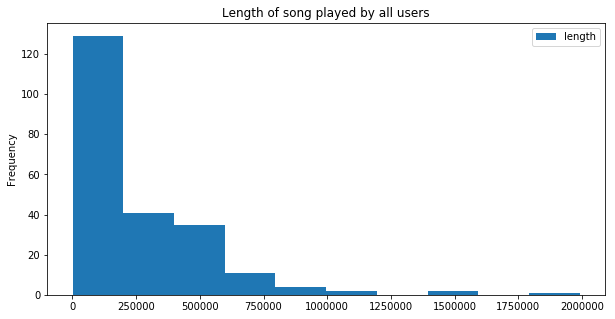

In [11]:
# Create histogram of length of sessions
length = df.select(['userId','length']).groupby('userId').agg(sum('length').alias('length')).sort('length',ascending=False).toPandas()
length.plot(kind='hist',figsize=(10,5),title='Length of song played by all users')


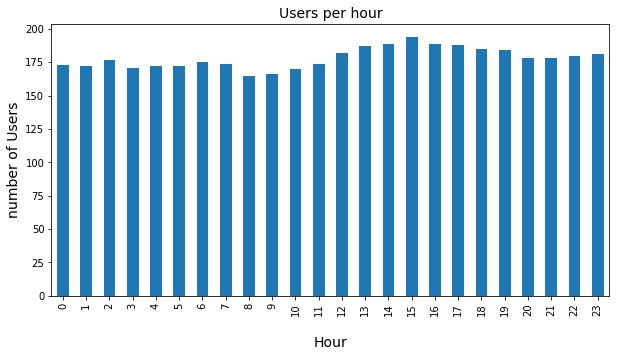

In [12]:
# User distribution per hour of the day
users_per_hour_pd = df_sub.select(['userId','hour']).dropDuplicates().groupby(['hour']).count().sort('hour').toPandas()

# Plot
ax = users_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('number of Users', fontsize=14)
plt.title('Users per hour', fontsize=14)
plt.show()

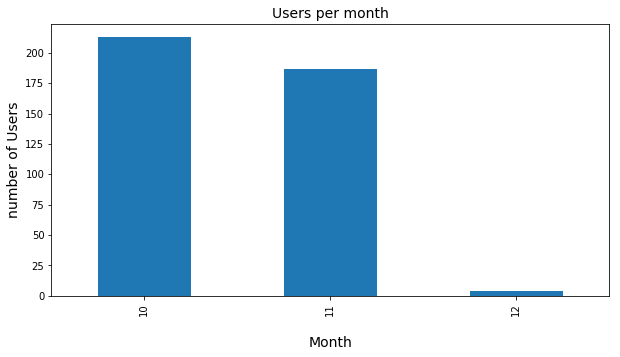

In [13]:
# User distribution per hour of the day
users_per_month_pd = df_sub.select(['userId','month']).dropDuplicates().groupby(['month']).count().sort('month').toPandas()

# Plot
ax = users_per_month_pd.plot(x='month', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nMonth', fontsize=14)
plt.ylabel('number of Users', fontsize=14)
plt.title('Users per month', fontsize=14)
plt.show()

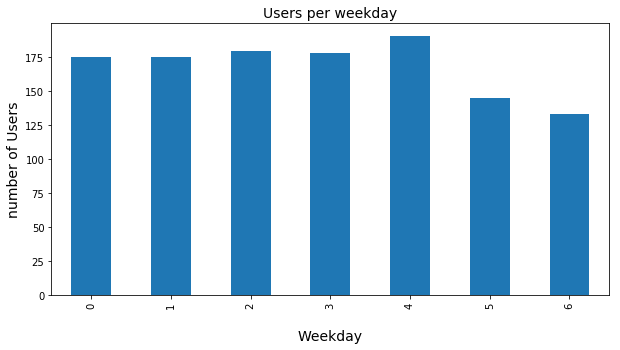

In [14]:
# User distribution per hour of the day
users_per_weekday_pd = df_sub.select(['userId','weekday']).dropDuplicates().groupby(['weekday']).count().sort('weekday').toPandas()

# Plot
ax = users_per_weekday_pd.plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nWeekday', fontsize=14)
plt.ylabel('number of Users', fontsize=14)
plt.title('Users per weekday', fontsize=14)
plt.show()

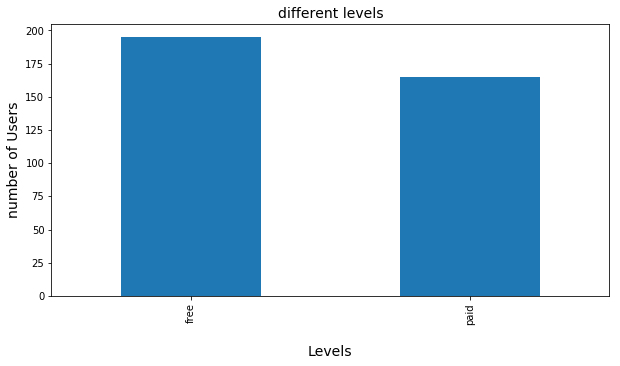

In [15]:
# User distribution per levels which contains free and paide users
users_per_hour_pd = df_sub.select(['userId','level']).dropDuplicates().groupby(['level']).count().sort('level').toPandas()

# Plot
ax = users_per_hour_pd.plot(x='level', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nLevels', fontsize=14)
plt.ylabel('number of Users', fontsize=14)
plt.title('different levels', fontsize=14)
plt.show()

***Adding churn flags to the data***

In [16]:
#define churn and downgraded users 
add_flag_churn_cancel_event=udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
add_flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
add_flag_churn_flags = udf(lambda x,y : x+y, IntegerType())


In [17]:
#add churn and downgrade columns to the data
df_sub = df.withColumn("churn_cancel", add_flag_churn_cancel_event("page"))
df_sub = df_sub.withColumn("churn_down", add_flag_downgrade_event ("page"))
df_sub = df_sub.withColumn("churned", add_flag_churn_flags ("churn_cancel","churn_down"))

In [18]:
users_per_hour_pd = df_sub.where(df_sub.churn_cancel==1).select(['userId','level']).dropDuplicates().groupby(['level']).count().sort('level').show()


+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



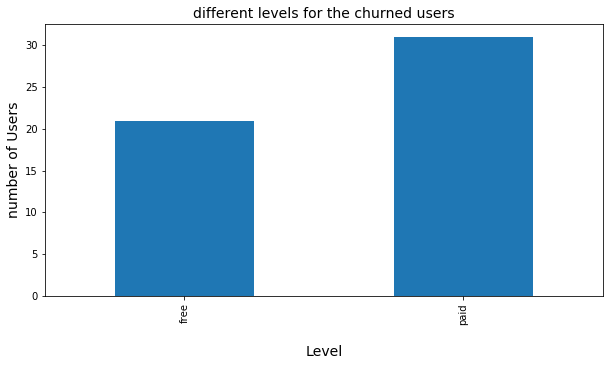

In [19]:
###### User distribution for churned users of the day
users_per_hour_pd = df_sub.where(df_sub.churn_cancel==1).select(['userId','level']).dropDuplicates().groupby(['level']).count().sort('level').toPandas()
#users_per_hour_pd =users_per_hour_pd[users_per_hour_pd['churned'] ==1][['level','count']]
# Plot
ax = users_per_hour_pd.plot(x='level', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nLevel', fontsize=14)
plt.ylabel('number of Users', fontsize=14)
plt.title('different levels for the churned users', fontsize=14)
plt.show()

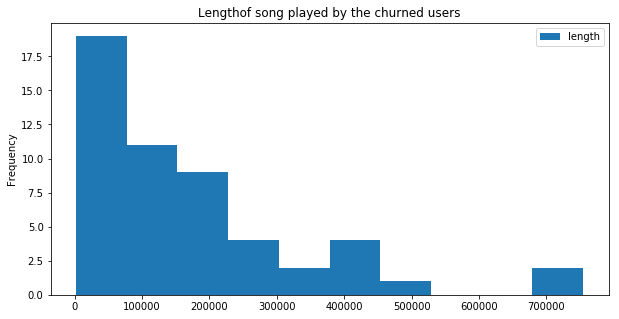

In [20]:
# User distribution for churned users of the day
churned_users = df_sub.where(df_sub.churn_cancel == 1).select("userId").collect()
churned_users_array = [row.userId for row in churned_users]
length = df.filter(df['userId'].isin(churned_users_array)).select(['userId','length']).groupby('userId').agg(sum('length').alias('length')).sort('length',ascending=False).toPandas()
length.plot(kind='hist',figsize=(10,5),title='Lengthof song played by the churned users')


In [21]:
# Churn per device
get_device = udf(lambda x: x.split('(')[1].replace(';', " ").split(" ")[0])
df_devices = df.withColumn('Device', get_device('userAgent'))

print('Churner per device')
df_devices.filter(df.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()


Churner per device
+---------+-----+
|   Device|count|
+---------+-----+
|      X11|    5|
|   iPhone|    4|
|Macintosh|   19|
|  Windows|   24|
+---------+-----+



As we can see there is only one browser in the suser agens so there is no need to onsider that as a feature.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**Session duration**

In [22]:
# Create Feature
session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(sum('ts').alias('avg_session_duration'))
session_duration = session_duration.drop('sessionId')
session_duration.show(5)


+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|     112317273376000|
|    42|      32312393582000|
|   101|    1315986300084000|
|   120|     401733634418000|
|   140|       9236549131000|
+------+--------------------+
only showing top 5 rows



**Churned flag in features**

In [28]:
# User definded function
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Create feature
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
# Validation
print('Number of rows: ' + str(churn.count()))
churn.show(5)

Number of rows: 225
+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



In [29]:
# User definded function
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Create feature
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))

# Validation
print('Number of rows: ' + str(gender.count()))
gender.show(5)

Number of rows: 225
+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|    51|     1|
|   124|     0|
+------+------+
only showing top 5 rows



In [30]:
# Create feature
length = df.select(['userId','length']).groupby('userId').agg(sum('length').alias('length'))

# Validation
print('Number of rows: ' + str(length.count()))
length.show(5)

Number of rows: 225
+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [31]:
# User definded function
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Create feature
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

# Validation
print('Number of rows: ' + str(level.count()))
level.show(5)

Number of rows: 225
+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



In [32]:
# User definded function
get_location = udf(lambda x: x.split(', ')[1].split('-')[0])
get_location_name = udf(lambda x: "location_"+x.replace(" ", "_").lower())

# Create feature
location = df.withColumn('location', get_location(df['location'])).select(['userId', 'location']).dropDuplicates(['userId'])\
           .groupBy('userId').pivot('location').agg(count('location')).fillna(0)

# Validation
print('Number of rows: ' + str(location.count()))
location.show(5)

Number of rows: 225
+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|userId| AK| AL| AR| AZ| CA| CO| CT| DC| FL| GA| IA| IL| IN| KY| LA| MA| MD| MI| MN| MO| MS| MT| NC| NE| NH| NJ| NV| NY| OH| OK| OR| PA| RI| SC| TN| TX| UT| VA| WA| WI| WV|
+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|100010|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|200002|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|   125|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0

**Users OS as a feature**

In [33]:
# User definded function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

# Validation
print('Number of rows: ' + str(userAgent.count()))
userAgent.show(5)

Number of rows: 225
+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|100010|        0|      0|  0|         0|   0|     1|
|200002|        0|      0|  0|         0|   0|     1|
|   125|        1|      0|  0|         0|   0|     0|
|   124|        1|      0|  0|         0|   0|     0|
|    51|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



**Number of songs played by a user as a feature**. 

In [34]:
# Create feature
songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

# Validation
print('Number of rows: ' + str(songs.count()))
songs.show(5)

Number of rows: 225
+------+-----+
|userId|songs|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows



In [35]:
# Create feature
length = df.select(['userId','length']).groupby('userId').agg(avg('length').alias('length'))

# Validation
print('Number of rows: ' + str(length.count()))
length.show(5)

Number of rows: 225
+------+------------------+
|userId|            length|
+------+------------------+
|100010|  243.421444909091|
|200002|242.91699209302305|
|   125|261.13913750000006|
|    51|247.88055082899118|
|   124|248.17653659965674|
+------+------------------+
only showing top 5 rows



In [36]:
# User definded function
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Create feature
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

# Validation
print('Number of rows: ' + str(level.count()))
level.show(5)

Number of rows: 225
+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



In [37]:
# User definded function
get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
exclude_page = ['Cancel', 'Cancellation Confirmation']

# Create feature
page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                 .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

# Validation
print('Number of rows: ' + str(page.count()))
page.show(5)

Number of rows: 225
+------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+
|userId|page_about|page_add_friend|page_add_to_playlist|page_downgrade|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_save_settings|page_settings|page_submit_downgrade|page_submit_upgrade|page_thumbs_down|page_thumbs_up|page_upgrade|
+------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+
|200002|         3|              4|                   8|             5|         0|        2|       20|          5|          387|               7|                 0|            3|    

In [38]:
# Create feature
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

# Validation
print('Number of rows: ' + str(time_since_reg.count()))
time_since_reg.show(5)

Number of rows: 225
+------+--------------+
|userId|time_since_reg|
+------+--------------+
|100010|    4807612000|
|200002|    6054448000|
|   125|    6161779000|
|   124|   11366431000|
|    51|    1680985000|
+------+--------------+
only showing top 5 rows



In [39]:
# User definded function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

# Validation
print('Number of rows: ' + str(userAgent.count()))
userAgent.show(5)

Number of rows: 225
+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|100010|        0|      0|  0|         0|   0|     1|
|200002|        0|      0|  0|         0|   0|     1|
|   125|        1|      0|  0|         0|   0|     0|
|   124|        1|      0|  0|         0|   0|     0|
|    51|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



In [40]:
#joining all the features
df = churn.join(session_duration, ['userId'])\
          .join(gender, ['userId'])\
          .join(length, ['userId'])\
          .join(level, ['userId'])\
          .join(location, ['userId'])\
          .join(page, ['userId'])\
          .join(time_since_reg, ['userId'])\
          .join(songs, ['userId'])\
          .join(userAgent, ['userId'])

In [41]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- avg_session_duration: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- AK: long (nullable = true)
 |-- AL: long (nullable = true)
 |-- AR: long (nullable = true)
 |-- AZ: long (nullable = true)
 |-- CA: long (nullable = true)
 |-- CO: long (nullable = true)
 |-- CT: long (nullable = true)
 |-- DC: long (nullable = true)
 |-- FL: long (nullable = true)
 |-- GA: long (nullable = true)
 |-- IA: long (nullable = true)
 |-- IL: long (nullable = true)
 |-- IN: long (nullable = true)
 |-- KY: long (nullable = true)
 |-- LA: long (nullable = true)
 |-- MA: long (nullable = true)
 |-- MD: long (nullable = true)
 |-- MI: long (nullable = true)
 |-- MN: long (nullable = true)
 |-- MO: long (nullable = true)
 |-- MS: long (nullable = true)
 |-- MT: long (nullable = true)
 |-- NC: long (nullable = true)
 |-- NE: long (nul

**chekcing and removing highly corealted features in data frame**

In [42]:
# Convert df to Pandas df
df_pd = df.toPandas()

In [43]:
# Correlation matrix
correlation_matrix = df_pd.corr('pearson')

# Too many features to visualize the matrix, so iterate rows and drop highly correlated rows
correlated_columns = []
for column in correlation_matrix.columns:
    correlated = correlation_matrix.drop(column, axis=0).loc[correlation_matrix[column].abs()>=0.5].index.tolist()
    if len(correlated) > 0:
        correlated_columns.append(column)  
        
# Show corelated columns
print('highly corealted columns:')
correlated_columns

highly corealted columns:


['MA',
 'page_about',
 'page_add_friend',
 'page_add_to_playlist',
 'page_downgrade',
 'page_error',
 'page_help',
 'page_home',
 'page_logout',
 'page_nextsong',
 'page_roll_advert',
 'page_save_settings',
 'page_settings',
 'page_submit_downgrade',
 'page_submit_upgrade',
 'page_thumbs_down',
 'page_thumbs_up',
 'page_upgrade',
 'songs',
 'Macintosh',
 'Windows',
 'iPad']

In [44]:
# Identify features that higly correlate with any other feature
max_corr = 0.75 # Set parameter for maximum permitted pearson correlation coefficient

# Loop over columns
highly_correlated_columns = []
counter = 0
for column in correlated_columns:
    if (column != 'churn') & (correlation_matrix[column].drop(column).max() > max_corr):
        counter += 1
        print(str(counter) + '. ' + str(column))
        highly_correlated_columns.append(column)     
        
print('\n{} highly correlated features (Pearson Correlation Coeffitient larger than {}) to drop.'.format(counter,max_corr))

1. page_about
2. page_add_friend
3. page_add_to_playlist
4. page_downgrade
5. page_help
6. page_home
7. page_logout
8. page_nextsong
9. page_roll_advert
10. page_save_settings
11. page_settings
12. page_submit_downgrade
13. page_submit_upgrade
14. page_thumbs_down
15. page_thumbs_up
16. page_upgrade
17. songs

17 highly correlated features (Pearson Correlation Coeffitient larger than 0.75) to drop.


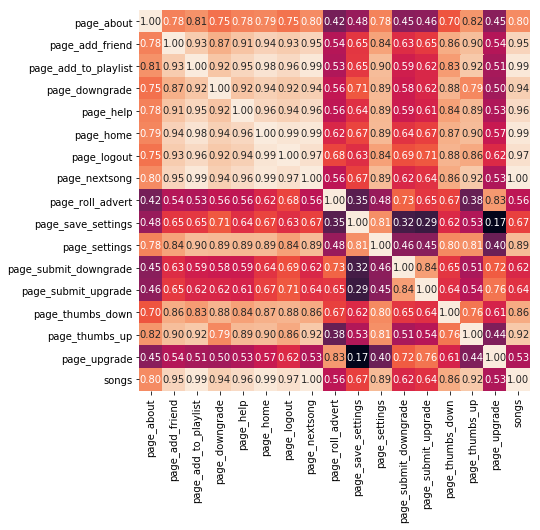

In [45]:
# Inspect highly correlated features
correlation_matrix_sub = df_pd[highly_correlated_columns].corr('pearson')

# Plot correlation matrix
ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(correlation_matrix_sub, annot = True, fmt = '.2f', cbar=False)  
plt.show()

In [46]:
# Drop features that higly correlate with any other feature
df_pd.drop(highly_correlated_columns, axis=1, inplace=True)

In [47]:
# Store names of features to keep for further analysis
features_to_keep = list(df_pd.columns)
print(features_to_keep)

['userId', 'churn', 'avg_session_duration', 'gender', 'length', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_error', 'time_since_reg', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']


In [48]:
# Select features to keep for further analysis from raw data and build a new Spark dataframe
df = df.select(features_to_keep)

# Convert to pandas
df_pd = df.toPandas()

# Print columns
df_pd.columns

Index(['userId', 'churn', 'avg_session_duration', 'gender', 'length', 'level',
       'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL',
       'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE',
       'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX',
       'UT', 'VA', 'WA', 'WI', 'WV', 'page_error', 'time_since_reg',
       'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone'],
      dtype='object')

In [49]:
# Check for missing values
missings = df_pd.isnull().sum().sum()
print('Number of missing values: {}'.format(missings))

Number of missing values: 0


Feature Scaling :

In [50]:
# Distribution of all numerical, non-binary features
num_features = [ 'page_error', 'time_since_reg']

In [51]:
df_pd[num_features]
plt.show()

In [52]:
# Vectorize features
assembler = VectorAssembler(inputCols=num_features, outputCol='FeatureVector')
df_assembled = assembler.transform(df)
# Standardize features
scaler = StandardScaler(inputCol='FeatureVector', outputCol='ScaledNumFeatures', withStd=True)
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

In [53]:
df_scaled.head()


Row(userId='100010', churn=0, avg_session_duration=172675084440000, gender=0, length=243.421444909091, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=1, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0, MS=0, MT=0, NC=0, NE=0, NH=0, NJ=0, NV=0, NY=0, OH=0, OK=0, OR=0, PA=0, RI=0, SC=0, TN=0, TX=0, UT=0, VA=0, WA=0, WI=0, WV=0, page_error=0, time_since_reg=4807612000, Macintosh=0, Windows=0, X11=0, compatible=0, iPad=0, iPhone=1, FeatureVector=DenseVector([0.0, 4807612000.0]), ScaledNumFeatures=DenseVector([0.0, 1.4762]))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [54]:
def load_data(path):
    '''
    Load a data set that is stored under a given path. Rows with missing ids will be removed.
    
    INPUT
    - path(string): Path where the data is stored
    
    OUTPUT
    - df(spark): Dataframe
    '''
    
    # Load small subset for feature engineering
    df = spark.read.json(path)

    # Drop rows with missing user id
    df = df.where(df.userId != '')
    
    return df

In [55]:
def feature_creation(df):
    '''
    The following Features will be creted at user level:

    1.  avg_session_duration: average session duration [float]
    2.  churn: "1" for a page cancellation confirmation (defined as churn), "0" for absence of churn [binary]
    3.  gender: "1" for male, "0" for female [binary]
    4.  length: total length of songs listened [float]
    5.  level: latest level of a user. "1" for paid, "0" for free [binary]
    6.  location: location of the user [binary]
    7.  page: number visits per page [int]
    8.  time_since_reg: time since registration [int]
    9.  sessions: total number of sessions [int]
    10. songs: total number of songs listend [int]
    11. userAgent: agents used by the user [binary]
    
    Afterwards, all features are joined, checked for multicollinearity and strongly correlating features will be removed.
    
    INPUT
    - path(string): Path where the data is stored
    
    OUTPUT
    - df(Dataframe): Dataframe
    '''
    
    # 1.  sum_session_duration
    avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId'])\
                                     .agg(sum('ts').alias('avg_session_duration'))
    avg_session_duration = avg_session_duration.drop('sessionId')

    # 2.  churn
    get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    churn = df.withColumn('churn', get_churn('page')).select(['userId','churn'])\
                          .groupby('userId').agg(max('churn').alias('churn'))

    # 3.  gender
    get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender'])\
                           .groupby('userId').agg(max('gender').alias('gender'))

    
    # 4.  length
    length = df.select(['userId','length']).groupby('userId').agg(sum('length').alias('length'))
    
    # 5.  level
    get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
    level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
                      .withColumn('level', get_level('level').cast(IntegerType()))
    
    # 6.  location
    get_location = udf(lambda x: x.split(', ')[1].split('-')[0])
    get_location_name = udf(lambda x: "location_"+x.replace(" ", "_").lower())
    location = df.withColumn('location', get_location(df['location'])).select(['userId', 'location'])\
                             .dropDuplicates(['userId']).groupBy('userId').pivot('location').agg(count('location')).fillna(0)
    
    # 7.  page
    get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
    exclude_page = ['Cancel', 'Cancellation Confirmation']
    page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                     .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)
    
    # 8.  time_since_reg
    df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
    df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
    time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])
    time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
    time_since_reg = time_since_reg.drop('max_ts')
    time_since_reg = time_since_reg.drop('reg_ts')
    
    # 9.  sessions
    sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))
    
    # 10. songs
    songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))
    
    # 11. userAgent
    get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
    userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent'])\
                              .dropDuplicates(['userId']).groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)
    
    # Bringing all together
    df = churn.join(avg_session_duration, ['userId'])\
          .join(gender, ['userId'])\
          .join(length, ['userId'])\
          .join(level, ['userId'])\
          .join(location, ['userId'])\
          .join(page, ['userId'])\
          .join(time_since_reg, ['userId'])\
          .join(sessions, ['userId'])\
          .join(songs, ['userId'])\
          .join(userAgent, ['userId'])
    
    # Check for multicollinearity
    df_pd = df.toPandas()
    correlation_matrix = df_pd.corr('pearson') # Correlation matrix   
    correlated_columns = []
    for column in correlation_matrix.columns: # Iterate rows and drop highly correlated rows
        correlated = correlation_matrix.drop(column, axis=0).loc[correlation_matrix[column].abs()>=0.75].index.tolist()
        if len(correlated) > 0:
            correlated_columns.append(column)  
            
    # Drop features that higly correlate with any other feature
    df_pd.drop(highly_correlated_columns, axis=1, inplace=True)
    features_to_keep = list(df_pd.columns)
    df = df.select(features_to_keep)
    
    # Check for missing values
    df_pd = df.toPandas()
    missings = df_pd.isnull().sum().sum()
    print('Number of missing values: {}'.format(missings))
    
    return df

In [56]:
def feature_scaling(df):
    '''
    Perform feature standardization on a set of given data to ensure the values in a feature follow the 
    normal distribution whereby mean of the values is 0 and standard deviation is 1. 
    
    INPUT
    - df: PySpark Dataframe
    
    OUTPUT
    - scaled_df: PySpark Dataframe with standardized features
    '''
    
    # Get features without ids and labels
    feature_cols = df.drop('userId', 'churn').columns
    print(str(len(feature_cols)) + ' Features for Scaling:\n')
    print(feature_cols)

    # Vector assembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='FeatureVector')
    
    # PySpark.ML expects the target column to be named as 'labelCol' af data type double
    df = df.withColumn('label', df['churn'].cast('float')).drop('churn')
    
    # Feature scaler    
    #scaler = StandardScaler(inputCol='FeatureVector', outputCol='ScaledFeatures', withStd=True)
    scaler = MinMaxScaler(inputCol='FeatureVector', outputCol='ScaledFeatures')
    
    # Perform assembling and standardizing of features
    df = assembler.transform(df)
    scalerModel = scaler.fit(df)
    scaled_df = scalerModel.transform(df)
    
    # Visulize example row
    print('\nExample row of scaled features:\n')
    print(scaled_df.head(1))
    
    # Just take scaled feature vector and labels
    scaled_df = scaled_df.select('ScaledFeatures', 'label')
    print('\nReduced to scaled feature vector and labels:\n')
    print(scaled_df.printSchema())
    print(scaled_df.head(1))
    
    return scaled_df

In [57]:
def train_test_split(scaled_df):
    '''
    Split the data into training set and test set. 
    
    INPUT
    - df: Scaled PySpark Dataframe
    
    OUTPUT
    - train_set: training set
    - test_set: test set
    '''
    
    # Train-test-validation split
    train_set, test_set = scaled_df.drop('userId').randomSplit([0.8, 0.2], seed=42)
    
    return train_set, test_set

In [71]:
def cross_validation(classifier, parameter_grid):
    '''
    Performs Cross validation 
    Cross validation is a technique for estimating the performance of a predictive model
    
    INPUT
    - classifier: untrained classifier
    - parameter_grid: a grid of parameters
    
    OUTPUT
    - crossval: cross validator
    '''

    crossval = CrossValidator(estimator = classifier,
                              estimatorParamMaps = parameter_grid,
                              evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds = 3)

    
    return crossval

In [69]:
def train_model(classifier, train_set, parameter_grid,base):
    '''
    Training of classification model
    
    INPUT
    - classifier: untrained classifier
    - train_set: training data
    - parameter_grid: a grid of parameters
    
    OUTPUT
    - model: trained classifier
    '''
    
    # Cross validation
    if base==False : 
        current_model = cross_validation(classifier, parameter_grid)
    else:
        current_model=classifier
                
    # Train model
    model = current_model.fit(train_set)
    
    return model

In [70]:
def evaluate_model(classifier, data):
    '''
    Evaluation of trained classification model
    
    INPUT
    - classifier: trained classifier
    - data: evaluation data
    
    OUTPUT
    - metrics : Disctionary of evaluation metrics
    '''
    
    # Predict
    predictions = classifier.transform(data)
    
    # Evaluator
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
    
    # Calculate metrics
    metrics = {}
    metrics['precision'] = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})
    metrics['recall'] = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})
    metrics['f1'] = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    metrics['accuracy'] = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
    metrics['confusion_matrix'] = predictions.groupby('label').pivot('prediction').count()
    
    return metrics

In [62]:
def ml_pipeline(model, path):
    '''
    Machine Learning pipeline that brings all steps together: 
    1. Load data
    2. Feature creation
    3. Feature Scaling
    4. Train-Test Split
    5. Build model
    6. Cross validation
    7. Model training
    8. Model evaluation
    
    INPUT
    - model: classification model to build
    - train_set: training data
    - test_set: test data
    
    OUTPUT
    - trained_classifier: trained model
    '''
    print('\nModel: ' + model + '\n')
    
    print('++++++++++++++++++++++++++++++++')
    print('1. Load Data')
    print('++++++++++++++++++++++++++++++++')
    
    df = load_data(path)
    
    print('++++++++++++++++++++++++++++++++')
    print('2. Feature Creation')
    print('++++++++++++++++++++++++++++++++')
    
    df = feature_creation(df)

    print('++++++++++++++++++++++++++++++++')
    print('3. Feature Scaling')
    print('++++++++++++++++++++++++++++++++')
    
    scaled_df = feature_scaling(df)
    
    print('++++++++++++++++++++++++++++++++')
    print('4. Train-Test Split')
    print('++++++++++++++++++++++++++++++++')
    
    train_set, test_set = train_test_split(scaled_df)
    
    print('++++++++++++++++++++++++++++++++')
    print('5. Build model')
    print('++++++++++++++++++++++++++++++++')
    parameter_grid = None  
    base = False
    if model == 'Random Forest':
        classifier = RandomForestClassifier(labelCol='label', featuresCol='ScaledFeatures',maxMemoryInMB = 1000, 
        seed=42)
        # Random forest with cross validation
        parameter_grid = ParamGridBuilder() \
        .addGrid(classifier.numTrees, [5,10,20]) \
        .addGrid(classifier.minInstancesPerNode, [5, 10, 20] ) \
        .build()
        file_name = 'randomforest_cf.model'
    if model == 'Base Random Forest':
        classifier = RandomForestClassifier(labelCol='label', featuresCol='ScaledFeatures',maxMemoryInMB = 1000  ,seed=42)
        base = True
        file_name = 'cv_randomforest_cf.model'    
    if model == 'Gradient Boosting':
        classifier = GBTClassifier(labelCol='label', featuresCol='ScaledFeatures')
        parameter_grid = ParamGridBuilder() \
        .addGrid(classifier.maxDepth, [5,10]) \
        .addGrid(classifier.minInstancesPerNode, [5, 15] ) \
        .build()
        file_name = 'gradientboo_cf.model'
    if model == 'Base Gradient Boosting':
        base= True
        classifier = GBTClassifier(labelCol='label', featuresCol='ScaledFeatures')
        file_name = 'cv_gradientboo_cf.model'
        
        
    print('++++++++++++++++++++++++++++++++')
    print('6. & 7. Cross Val. & Training')
    print('++++++++++++++++++++++++++++++++')
    
    trained_classifier = train_model(classifier, train_set, parameter_grid,base)
    
    # Get best model
    if base == False :
        bestModel = trained_classifier.bestModel
        trained_classifer=bestModel
    
        # Save trained model
        bestModel.write().overwrite().save(file_name)
    else:
        trained_classifier.write().overwrite().save(file_name)
    
    print('++++++++++++++++++++++++++++++++')
    print('8. Model Evaluation')
    print('++++++++++++++++++++++++++++++++')
    
    metrics = evaluate_model(trained_classifier, test_set)
    print(metrics)
    
    return metrics

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [72]:
# 1. Model: Random Forest Classifier
Base_random_forest_metrics = ml_pipeline('Base Random Forest', 'mini_sparkify_event_data.json')


Model: Base Random Forest

++++++++++++++++++++++++++++++++
1. Load Data
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
2. Feature Creation
++++++++++++++++++++++++++++++++
Number of missing values: 0
++++++++++++++++++++++++++++++++
3. Feature Scaling
++++++++++++++++++++++++++++++++
54 Features for Scaling:

['avg_session_duration', 'gender', 'length', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_error', 'time_since_reg', 'sessions', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='100010', avg_session_duration=172675084440000, gender=0, length=66940.89735000003, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=1, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0, MS

In [73]:
# 1. Model: Random Forest Classifier
cv_random_forest_metrics = ml_pipeline('Random Forest', 'mini_sparkify_event_data.json')


Model: Random Forest

++++++++++++++++++++++++++++++++
1. Load Data
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
2. Feature Creation
++++++++++++++++++++++++++++++++
Number of missing values: 0
++++++++++++++++++++++++++++++++
3. Feature Scaling
++++++++++++++++++++++++++++++++
54 Features for Scaling:

['avg_session_duration', 'gender', 'length', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_error', 'time_since_reg', 'sessions', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='100010', avg_session_duration=172675084440000, gender=0, length=66940.89735000003, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=1, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0, MS=0, M

In [74]:
## 1. Model: Random Forest Classifier
base_gradient_boosting_metrics = ml_pipeline('Base Gradient Boosting', 'mini_sparkify_event_data.json')


Model: Base Gradient Boosting

++++++++++++++++++++++++++++++++
1. Load Data
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
2. Feature Creation
++++++++++++++++++++++++++++++++
Number of missing values: 0
++++++++++++++++++++++++++++++++
3. Feature Scaling
++++++++++++++++++++++++++++++++
54 Features for Scaling:

['avg_session_duration', 'gender', 'length', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_error', 'time_since_reg', 'sessions', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='100010', avg_session_duration=172675084440000, gender=0, length=66940.89735000003, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=1, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0

In [ ]:
# 1. Model: Random Forest Classifier
cv_gradient_boosting_metrics = ml_pipeline('Gradient Boosting', 'mini_sparkify_event_data.json')


Model: Gradient Boosting

++++++++++++++++++++++++++++++++
1. Load Data
++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++
2. Feature Creation
++++++++++++++++++++++++++++++++
Number of missing values: 0
++++++++++++++++++++++++++++++++
3. Feature Scaling
++++++++++++++++++++++++++++++++
54 Features for Scaling:

['avg_session_duration', 'gender', 'length', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_error', 'time_since_reg', 'sessions', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='100010', avg_session_duration=172675084440000, gender=0, length=66940.89735000003, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=1, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0, MS=